### TP 3

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

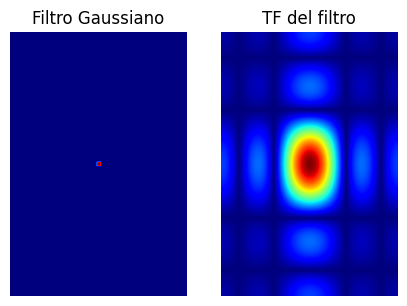

In [108]:
def create_gauss_filter(h, w, k_size, sigma):
    canvas = np.zeros((h, w))
    kernel = cv.getGaussianKernel(k_size, sigma)
    
    kernel = kernel @ kernel.T
    
    start_y = h // 2 - kernel.shape[0] // 2
    start_x = w // 2 - kernel.shape[1] // 2
    
    canvas[
        start_y : start_y + kernel.shape[0],
        start_x : start_x + kernel.shape[1],
    ] = kernel
    
    return canvas, np.fft.fft2(canvas)
    

gaussian_filter, filter_tf = create_gauss_filter(300, 200, k_size=5, sigma=5)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Filtro Gaussiano")
plt.imshow(gaussian_filter, cmap="jet")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("TF del filtro")
plt.imshow(np.abs(np.fft.fftshift(filter_tf)), cmap="jet")
plt.show()

In [111]:
def filter_image_spectral(img, k_size, sigma):
    _, filter_tf = create_gauss_filter(img.shape[0],img.shape[1],k_size=k_size,sigma=sigma)
    img_fft = np.fft.fft2(img)
    filtered = img_fft * filter_tf
    return np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

In [ ]:
def filter_spatial_domain

In [112]:
def plot_filtered_image(image, filter_func, combinations, col_row=(4,3)):
    num_images = len(combinations)
    cols, rows = col_row
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()

    for i, (k, s) in enumerate(combinations):
        filtered_image = filter_func(image, k, s)
        ax = axes[i]
        ax.imshow(filtered_image, cmap='gray')
        ax.set_title(f"k={k}, sigma={s}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

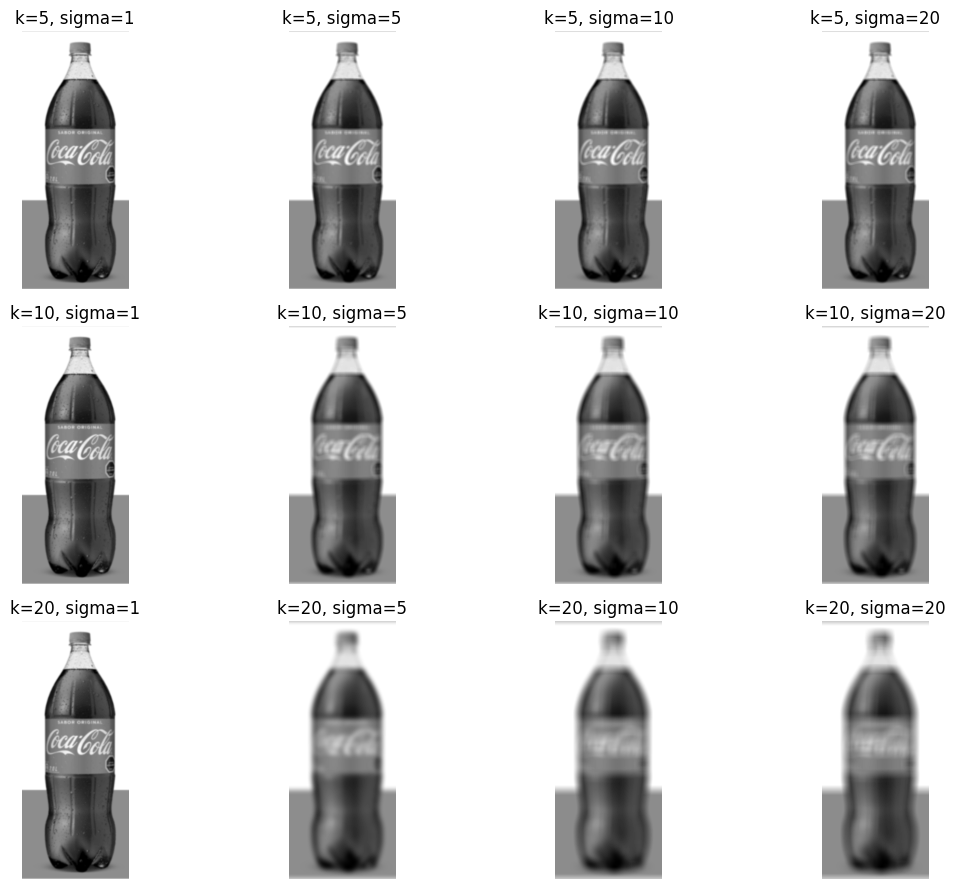

In [113]:
original_img = cv.imread('./TP3/images/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
k_size = [5, 10, 20]
sigma = [1, 5, 10, 20]

combinations = [(k, s) for k in k_size for s in sigma]
plot_filtered_image(original_img, filter_image_spectral, combinations)

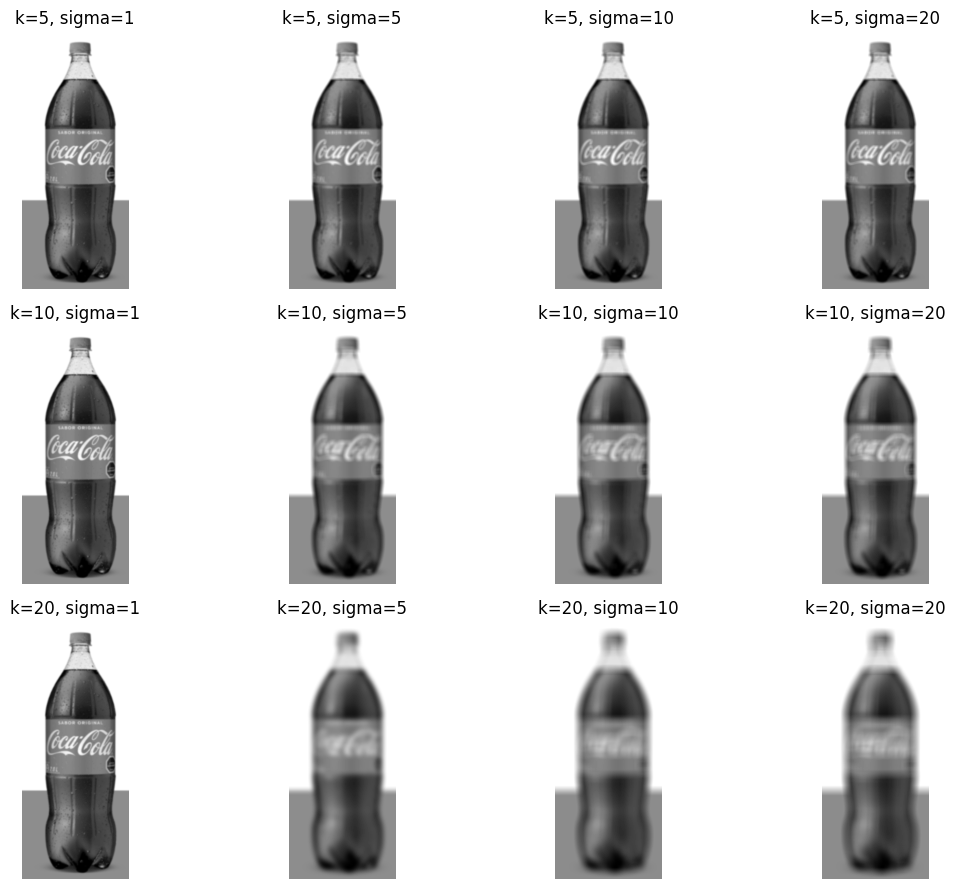

In [115]:
def filter_image_conv(img, k_size, sigma):
    kernel = cv.getGaussianKernel(k_size, sigma)
    kernel = kernel @ kernel.T
    return cv.filter2D(img, -1, kernel)

plot_filtered_image(original_img, filter_image_conv, combinations)

In [ ]:
from scipy.fft import fft2, fftshift

def freq_focus_measure(img):
    f = fft2(img)
    fc = fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(af > thres)
    fm = th / (img.shape[0] * img.shape[1])
    return fm

In [116]:
print('Quality measure original image:', freq_focus_measure(img))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(filtered_image))
print('Quality measure filtered image using frequency focus measure:', freq_focus_measure(filter_image_conv))


Quality measure original image: 1.6422397994774116
Quality measure filtered image using frequency focus measure: 0.02335265700483092


TypeError: float() argument must be a string or a real number, not 'function'

In [ ]:
def tenengrad_variance(img):
    sx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=5)
    sy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=5)
    tenengrad = cv.magnitude(sx, sy)
    return tenengrad.var()

In [ ]:
tenengrad_var_original = tenengrad_variance(img)
print("Varianza tenengrad de la imagen original", tenengrad_var_original)

tenengrad_var_fft_filtered = tenengrad_variance(filtered_image)
print("Varianza tenengrad de la imagen con filtrado espectral", tenengrad_var_fft_filtered)

#tenengrad_var_conv_filtered = tenengrad_variance(filtered_image_conv)
#print("Varianza tenengrad de la imagen con filtrado convolucional", tenengrad_var_conv_filtered)


In [ ]:
def Lx(img):
  kernelx = np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernelx))

def Ly(img):
  kernely = kernelx = np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernely))

def modified_laplacian(img):
  return (np.abs(Lx(img)) + np.abs(Ly(img))).mean()

In [ ]:
modified_laplacian_var_original = modified_laplacian(image)
print("Modified laplacian de la imagen original", modified_laplacian_var_original)

modified_laplacian_fft_filtered = modified_laplacian(filtered_image)
print("Modified laplacian de la imagen con filtrado espectral", modified_laplacian_fft_filtered)

#modified_laplacian_conv_filtered = modified_laplacian(filtered_image_conv)
#print("Varianza tenengrad de la imagen con filtrado convolucional", modified_laplacian_conv_filtered)
